# Coarse Writeup

Goal is to have a QP that can handle crazy stuff via a QP for haptic bilateral
position-position (or position-force) coupling, but not go (too) crazy itself.

With a (hopefully) simple and robust enough formulation, can then extend to other
tasks (e.g. dual-arm frame lock, etc.).

## References

- [H 84] Hogan, Neville. \
  “Impedance Control: An Approach to Manipulation.” In 1984 American Control Conference, 304–13, 1984. https://doi.org/10.23919/ACC.1984.4788393.

- [K 87] Khatib, O. \
  “A Unified Approach for Motion and Force Control of Robot Manipulators: The Operational Space Formulation.” IEEE Journal on Robotics and Automation 3, no. 1 (February 1987): 43–53. https://doi.org/10.1109/JRA.1987.1087068.

- [Tedrake Diff IK] <https://manipulation.csail.mit.edu/pick.html#section6>

- [ACENST 19] Ames, Aaron D., Samuel Coogan, Magnus Egerstedt, Gennaro Notomista, Koushil Sreenath, and Paulo Tabuada. \
  “Control Barrier Functions: Theory and Applications.” arXiv, March 26, 2019. https://doi.org/10.48550/arXiv.1903.11199.

- [WPHED 22] Wensing, Patrick M., Michael Posa, Yue Hu, Adrien Escande, Nicolas Mansard, and Andrea Del Prete. \
  “Optimization-Based Control for Dynamic Legged Robots.” arXiv, November 21, 2022. https://doi.org/10.48550/arXiv.2211.11644.

- [COMC 19] Cortez, Wenceslao Shaw, Denny Oetomo, Chris Manzie, and Peter Choong. \
  “Control Barrier Functions for Mechanical Systems: Theory and Application to Robotic Grasping.” arXiv, March 23, 2019. https://doi.org/10.48550/arXiv.1903.09816.

- [KWL 21] Kurtz, Vince, Patrick M. Wensing, and Hai Lin. \
  “Control Barrier Functions for Singularity Avoidance in Passivity-Based Manipulator Control.” arXiv, September 27, 2021. http://arxiv.org/abs/2109.13349.

- [D 18] Del Prete, Andrea. \
  “Joint Position and Velocity Bounds in Discrete-Time Acceleration/Torque Control of Robot Manipulators.” IEEE Robotics and Automation Letters 3, no. 1 (January 2018): 281–88. https://doi.org/10.1109/LRA.2017.2738321.

## Background

Given dynamics:

\begin{align*}
    M \dot{v} + C &= \tau + \tau_g & & \text{Inverse Dyn} \\
    M \dot{v} + H &= \tau \\
    H &= C - \tau_g \\
    \dot{v} &= M^{-1} (\tau - H) & & \text{Forward Dyn}
\end{align*}

For a primary task $t$ of tracking frame $G$ w.r.t. world frame $W$, we have error
dynamics:

\begin{align*}
    e_t &= {}^WX^G_{actual} \ominus {}^WX^G_{desired} \\
    J_t &= {}^WJ^G_v \\
    \dot{e}_t &= J_t v - {}^WV^G_{desired} \\
    \ddot{e}_t &= J_t \dot{v} + \dot{J}_t v - {}^WA^G_{desired}
\end{align*}

For secondary posture task $p$ of holding nominal joint position:

\begin{align*}
    e_p &= q - q_0 \\
    \dot{e}_p &= v \\
    \ddot{e}_p &= \dot{v}
\end{align*}

For nominal inverse dynamics in task space, w/ inverse dynamics in null-space,
avoiding singularities, we have the following control laws via operational
space / impedance control / feedback linearization:

\begin{align*}
    \ddot{e}_{t,c} &= -k_{t,p} e_t - k_{t,d} \dot{e}_t + {}^WA^G_{desired}  \\
    \ddot{e}_{p,c} &= -k_{p,p} e_p - k_{p,d} \dot{e}_p \\
    \tau &= H + J_t^T M_t (\ddot{e}_{t,c} - \dot{J}_t v) + N_t^T M \ddot{e}_{p,c} \\
    M_t^{-1} &= J_t M^{-1} J_t^T \\
    \bar{J}_t &= M^{-1} J_t^T M_t \\
    N_t^T &= I - J_t^T \bar{J}^T  \\
\end{align*}

## Basic Formluation

Our goal is to drive $\ddot{e}_t \rightarrow \ddot{e}_{t,c}$, and (in the null-space of
primary task $t$) $\ddot{e}_p \rightarrow \ddot{e}_{p,c}$.

Note that we also have some feasibility limits, $(q, v, \dot{v}, \tau) \in \mathbb{L}$,
and we want the tight convergence / precision of feedback linearization when possible,
and we want to scale back the desired feedback and feedforward otherwise, so we introduce
scaling similar to Drake's Diff IK formulation:

\begin{align*}
    \ddot{e}_t & \rightarrow \text{diag}(\ddot{e}_{t,c}) \bar{S}_t s_t \\
    \ddot{e}_p & \rightarrow s_p \ddot{e}_{p,c} \\
\end{align*}

where $s_t \in \mathbb{R}^{n_{s,t}}, s_p \in \mathbb{R}$ are decision variables, and
$\bar{S}_t \in \mathbb{R}^{6 \times n_{s,t}}$ allows to decide which (constant) subspaces
to align, e.g.

\begin{align*}
    \bar{S}_t &= I_{6 \times 6}  & \text{Decouple all axes} \\
    \bar{S}_t &= \mathbf{1}_{6 \times 1}  & \text{Couple all axes}  \\
    \bar{S}_t &= \begin{bmatrix}
        \mathbf{1}_{3 \times 1} & \mathbf{0}_{3 \times 1}  \\
        \mathbf{0}_{3 \times 1} & \mathbf{1}_{3 \times 1}
        \end{bmatrix}  & \text{Couple rotation and translation separately}
\end{align*}

We can write this implicitly, e.g.,

\begin{align*}
    \min_{s_t, s_p, \dot{v}, \tau} \hspace{10pt} &
        \sum_i (s_{t,i} - 1)^2 + (s_p - 1)^2 \\
    \text{s.t.} \hspace{10pt}
        &  M \dot{v} + H = \tau \\
        & \ddot{e}_t = \text{diag}(\ddot{e}_{t,c}) \bar{S}_t s_t \\
        & N_t^T M \ddot{e}_p = N_t^T M \ddot{e}_{p,c} s_p \\
        & \left(\hat{q}(\dot{v}), \hat{v}(\dot{v}), \dot{v}, \tau\right) \in \mathbb{L}
\end{align*}
where $(q_k, v_k)$ are the measured positions and velocities, and $\hat{q}$ and $\hat{v}$ are
naive approximations of the next position + velocities contingent upon our solution, e.g
\begin{align*}
    \hat{v}(\dot{v}) &= v_k + h_t \dot{v} \\
    \hat{q}(\dot{v}) &= q_k + h_t v_k + \frac{1}{2} h_t^2 \dot{v}
\end{align*}
where $h_t$ is our expected controller timestep.

We can also write this explicitly as affine expressions:

\begin{align*}
    \min_{s_t, s_p} \hspace{10pt} &
        \sum_i (s_{t,i} - 1)^2 + (s_p - 1)^2 \\
    \text{s.t.} \hspace{10pt}
        & (q(s), v(s), \dot{v}(s), \tau(s)) \in \mathbb{L}
\end{align*}
where
\begin{align*}
    \tau(s) &= A_\tau s + b_\tau \\
        &= H +
            J_t^T M_t \text{diag}(\ddot{e}_{t,c}) \bar{S}_t s_t +
            N_t^T M \ddot{e}_{p,c} s_p \\
    \dot{v}(s) &= A_{\dot{v}} s + b_{\dot{v}} \\
    \hat{v}(s) &= A_{v} s + b_v \\
    \hat{q}(s) &= A_{q} s + b_q
\end{align*}

The explicit form *seems* to be slightly better conditioned for solvers like SNOPT, OSQP,
and CLP.


## Imposing Limits

### TL;DR

You can (very hackily) scale the gains independently on position + velocity integration starting
from the values based on the timestep.

Singularity avoidance per [KWL 21] is uber nice.

### Resulting Scales

For this setup, running controller at 500 Hz, divide position gains by $20^2$, velocity gains by $10$

:shrug:

### Singularity Avoidance

Implement as in [KWL 21]. Gains were based on timestep, but uniformly dividing gains by $5^2$ for
position and $5$ for velocity.

:shrug: x2

### Verbose

While imposing the limits as the naive time-stepping form above is nice and simple, it can go
sideways (as stated in literature) - e.g. discretization errors, greedy nature of a single-step
QP, etc.

Also, as shown in [D 18], it could induce chatter, which ain't really desireable.

That can be side-stepped by scaling the timestep as stated in [D 18], but could run into issues with
QP feasibility (need to substantiate, tho), or it could be overly damped / conservative.

While the provision in [D 18] and follow up work are great analyses, I (Eric) had trouble getting it
to work much better than just the naive formulation, esp. where torque bounds start to affect
acceleration bounds - I'm still a bit conserved about the overly conservative apporach of their estimate
for this. It would be nice to check the accel bounds at an instant due to torque limits, but that
transformation may not be a strict bounding box (e.g. skewed rotations could happen), thus are
incompatible with that formulation.

Maybe a better formluation is MPC as stated there too, but it would still be nice to see what a
greedy single-step QP could achieve.

One nice perspective is to look at the formulation as a CBF. At present, it's actually an (ironic)
way to "hack" (look at what "gains" looks like) rather than the more formal side (certificates, and
handling discretization via Lipschitz).moreso to see what the "gains" look
like - and hopefully later to find / write a paper with more formal methods to generate nice
limits / certificates for the discretized case (a la [COMC 19]).

First, note the simplified form of CBFs as stated after Eq. (18) in [ACENST 19], and succinctly in
Eq. (21) in [KWL 21], for relative degree (RD) $n$:

\begin{align*}
    h^{(n)} & \ge -K \alpha(H) \\
    H &= \begin{bmatrix}
        h & \dot{h} & \text{...} & h^{(n-1)}
        \end{bmatrix}^{T} \\
\end{align*}

So for RD1 (velocity) and RD2 (position):

\begin{align*}
    \dot{h} & \ge -k_1 \alpha_1(h) & \text{RD1} \\
    \ddot{h} & \ge -k_1 \alpha_1(h) -k_2 \alpha_2(\dot{h}) & \text{RD2}
\end{align*}

So now looking at a CBF for lower velocity bounds $v_l$ and comparing it to the naive form:
\begin{align*}
    \hat{v} & \ge v_l \\
    v_k + h_t \dot{v} & \ge v_l \\
    \dot{v} & \ge \frac{1}{h_t} (v_l - v_k)  & \text{Naive} \\
    \\
    h_{v} &= v_k - v_l \\
    \dot{h}_{v,l} &= \dot{v} \\
    \dot{v} & \ge -k \alpha(h_{v,l})  & \text{CBF}
\end{align*}
Note the two are equivalent with $k = \frac{1}{h_t}, \alpha(x) = x$.

If you look the position form for $q \ge q_l, h_{q,l} = q - q_l \ge 0$, you have equivalence with
$k_1 = \frac{2}{h_t^2}, k_2 = \frac{2}{h_t}, \alpha_1(x) = \alpha_2(x) = x$.

Thus, you have starting gains that you can (independently, if so desired) tune or scale.


# Results

The following captures plots from running a reference trajectory that drives towards initial orientation
of gripper and a position that should either extend towards singularity and/or workspace limits based on
orientation, then do the inverse.

It's a tad aggressive to also check behavior at bounds.

This is for a controller running discretely (ZOH) with timestep of 2 ms (500 Hz).
This is tested on a `MultibodyPlant` using SAP with a timestep of 0.8 ms.

In [1]:
from functools import partial

from control_study.main import (
    make_controller_qp_constraints,
    np_print_more_like_matlab,
    run_fast_waypoints_singular,
)

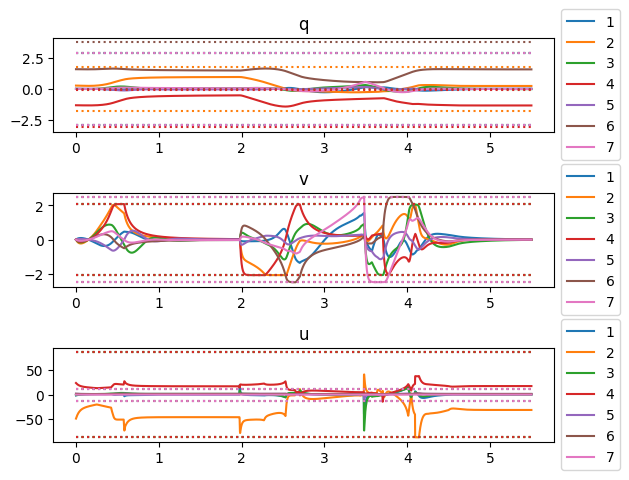

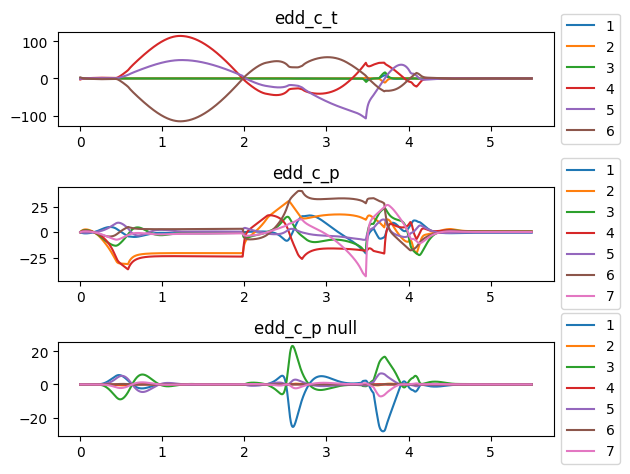

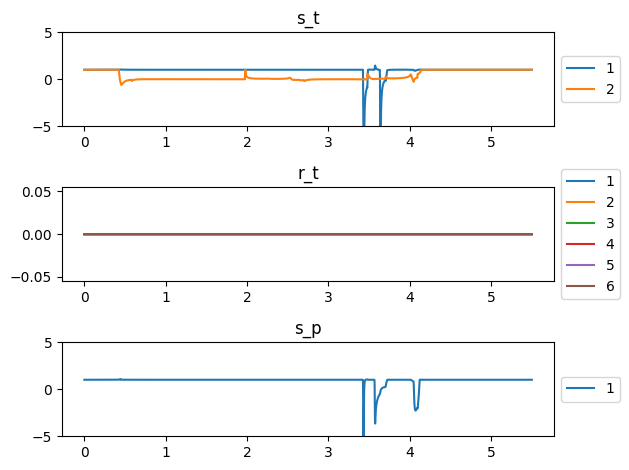

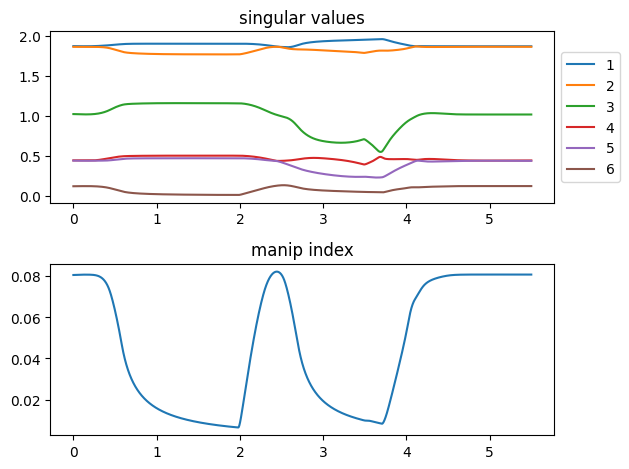

In [2]:
run_fast_waypoints_singular(make_controller_qp_constraints, rotate=False)